In [17]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:

import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools as nd
import math as m

In [19]:
instr = np.load('instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)


In [20]:
nside = 64
freq_maps = get_observation(instrument, 'd0s0', noise=False, nside=nside)


In [21]:

components= [CMB(), Dust(50.), Synchrotron(50.)]

In [22]:

A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
#invN=np.linalg.inv(np.eye(len(instrument.frequency)))
invN = np.diag((hp.nside2resol(nside, arcmin=True) / instrument.depth_p)**2)

In [7]:
def spectral_likelihood(x):
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =A_ev(x) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    #print(x,logL)
    if logL != logL:
        return 0.0
    return -logL

In [8]:
x0 =np.array([1.4,39,-2.5]) 

min_= minimize (spectral_likelihood, x0, method='Nelder-Mead')
print(min_)
print(min_.x)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -73858400703769.53
             x: [ 1.540e+00  2.000e+01 -3.000e+00]
           nit: 228
          nfev: 484
 final_simplex: (array([[ 1.540e+00,  2.000e+01, -3.000e+00],
                       [ 1.540e+00,  2.000e+01, -3.000e+00],
                       [ 1.540e+00,  2.000e+01, -3.000e+00],
                       [ 1.540e+00,  2.000e+01, -3.000e+00]]), array([-7.386e+13, -7.386e+13, -7.386e+13, -7.386e+13]))
[ 1.54000002 19.99999149 -2.9999668 ]


(6, 192)


Text(0.5, 0, '$\\ell$')

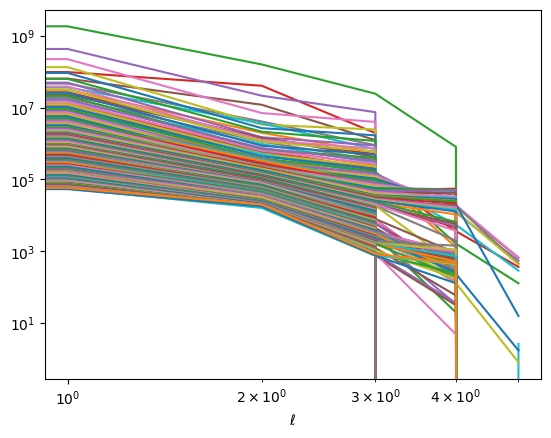

In [9]:
x0= np.array([1.54,20,-3])
invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
A_maxL =A_ev(min_.x) 
AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
s = AtNA.dot(AtNd)
ps_CMB =hp.anafast(s[0])
#ps_CMB =hp.sphtfunc.anafast(s[0])
plt.loglog(ps_CMB)
print (ps_CMB.shape)
plt.xlabel(r'$\ell$')



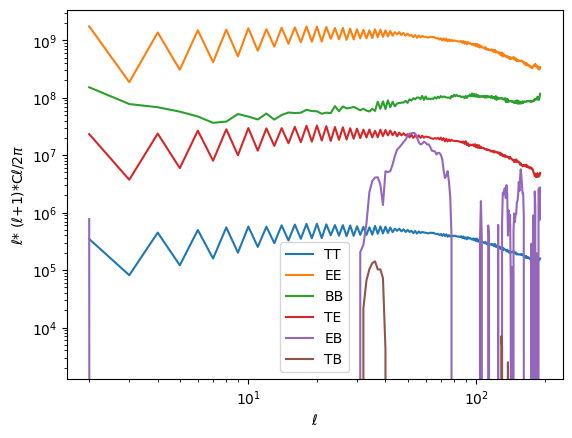

In [10]:
x0= np.array([1.54,20,-3])
invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
A_maxL =A_ev(min_.x) 
AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
s = AtNA.dot(AtNd)

ps_CMB =hp.anafast(s[0])
ps_CMB=ps_CMB.T
ps_CMB=ps_CMB[2:,:]

ell = np.arange(2,192)

values = []
for i in range(len(ps_CMB[0,:])):
    y = (ell*(ell+1)*ps_CMB[:,i])/(2*m.pi)
    values.append(y)


plt.loglog(ell,values[0], label="TT")
plt.loglog(ell,values[1], label="EE")
plt.loglog(ell,values[2], label="BB")
plt.loglog(ell,values[3], label="TE")
plt.loglog(ell,values[4], label="EB")
plt.loglog(ell,values[5], label="TB")


plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()

In [11]:

print(spectral_likelihood(x0))

-73858400703768.45


In [12]:
H = nd.Hessian(spectral_likelihood)
h = H([1.54, 20, -3])
print(h)




[[2.16078051e+12 5.88124210e+10 5.03421452e+09]
 [5.88124210e+10 1.61795523e+09 1.22881807e+08]
 [5.03421452e+09 1.22881807e+08 5.36193029e+07]]


[2.16239301e+12 1.07594397e+07 4.83105959e+07] [[ 0.99962708 -0.02573651 -0.00912912]
 [ 0.02720819  0.91017117  0.41333783]
 [ 0.00232881  0.41343207 -0.91053199]]


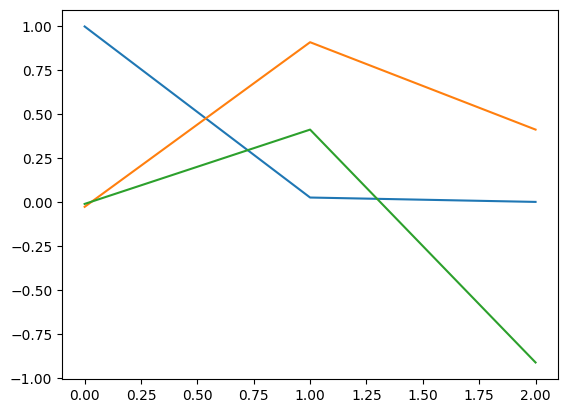

In [13]:
w, v = np.linalg.eig(h)
print(w,v)
plt.plot(v)

In [14]:
def spectral_likelihood(y):
    Bd, T, Bs, a = y
    b = 1
    G = np.diag([a,a,a,a,a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,b,b,b])
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    #print(i,logL)
    if logL != logL:
        return 0.0
    return -logL

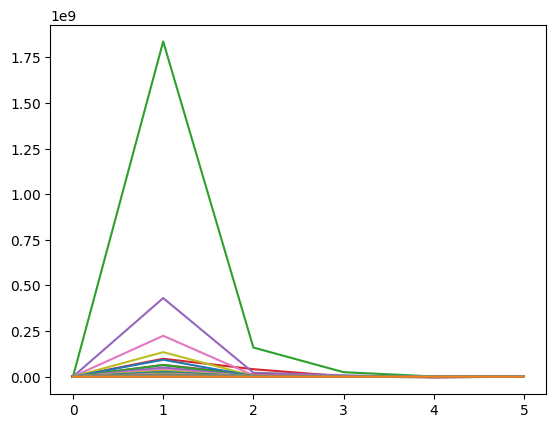

In [15]:
x0= np.array([1.54,20,-3,1])
a, b = 1, 1
G = np.diag([a,a,a,a,a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,b,b,b])
invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
A_maxL =G.dot(A_ev(x0)) 
AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
s = AtNA.dot(AtNd)
Q =hp.sphtfunc.anafast(s[0])
plt.plot(Q)


In [16]:
x0 =np.array([1.4, 21, -2.5, 1])  
min_= minimize (spectral_likelihood,x0,method='trust-constr', tol= 1e-18)
print(min_)
print(min_.x)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -73858396471067.56
                x: [ 1.525e+00  2.050e+01 -2.478e+00  9.998e-01]
              nit: 119
             nfev: 570
             njev: 114
             nhev: 0
         cg_niter: 337
     cg_stop_cond: 2
             grad: [ 1.512e+07  2.506e+06  4.232e+05  6.082e+07]
  lagrangian_grad: [ 1.512e+07  2.506e+06  4.232e+05  6.082e+07]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 60817408.0
 constr_violation: 0
   execution_time: 13.394520044326782
        tr_radius: 8.755295302056433e-19
   constr_penalty: 1.0
            niter: 119
[ 1.52542748 20.4997723  -2.4778971   0.99978987]


In [17]:
def spectral_likelihood(y):
    Bd, T, Bs, a, c = y
    b = 1
    G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    #print(i,logL)
    if logL != logL:
        return 0.0
    return -logL

In [18]:
x0 =np.array([1.4, 21, -2.5, 1, 1])  
min_= minimize (spectral_likelihood,x0,method='trust-constr', tol= 1e-18)
print(min_)
print(min_.x)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -73858395857031.06
                x: [ 1.512e+00  2.100e+01 -2.497e+00  9.977e-01  9.988e-01]
              nit: 43
             nfev: 222
             njev: 37
             nhev: 0
         cg_niter: 90
     cg_stop_cond: 2
             grad: [ 1.526e+07  6.990e+06  4.619e+06  1.887e+07  2.307e+07]
  lagrangian_grad: [ 1.526e+07  6.990e+06  4.619e+06  1.887e+07  2.307e+07]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 23068672.0
 constr_violation: 0
   execution_time: 5.16323184967041
        tr_radius: 6.070120594079025e-19
   constr_penalty: 1.0
            niter: 43
[ 1.51213953 21.00289913 -2.49694264  0.99769969  0.99881595]


In [19]:
H = nd.Hessian(spectral_likelihood)
h = H([1.54, 20, -3, 1.1, 1.5])
print(h)

[[ 1.77189916e+12  5.02288344e+10  3.17769468e+10  4.88771005e+09
  -4.33912847e+11]
 [ 5.02288344e+10  2.36248450e+09  7.49183805e+08 -6.97031561e+06
  -1.10575686e+10]
 [ 3.17769468e+10  7.49183805e+08 -2.05924446e+09  1.06199603e+10
  -1.01363541e+10]
 [ 4.88771005e+09 -6.97031561e+06  1.06199603e+10  1.20791979e+10
   2.69111499e+10]
 [-4.33912847e+11 -1.10575686e+10 -1.01363541e+10  2.69111499e+10
   2.64306724e+11]]


[ 1.88985507e+12  1.53625135e+11  1.38633950e+10  9.17678452e+08
 -9.67295497e+09] [[-0.96558457  0.25325739 -0.04880139 -0.03151771  0.01149748]
 [-0.02721436  0.01476073 -0.03177186  0.99899093 -0.00701241]
 [-0.01760543  0.00291721  0.54605951  0.0227212   0.83724805]
 [ 0.00108554  0.18930953  0.82175236  0.01959705 -0.53712172]
 [ 0.25805947  0.94857588 -0.15215465 -0.01111132  0.10165925]]


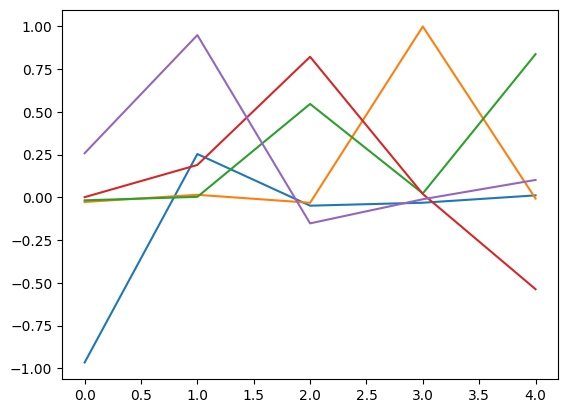

In [20]:
w, v = np.linalg.eig(h)
print(w,v)
plt.plot(v.T)

In [23]:
def spectral_likelihood(y):
    Bd, T, Bs, a, c, d, e, f = y
    b = 1
    G = np.diag([a,a,a,a,b,b,b,b,c,c,c,c,d,d,d,d,e,e,e,f,f,f])
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    #print(i,logL)
    if logL != logL:
        return 0.0
    return -logL

In [24]:
x0 =np.array([1.4, 21, -2.5, 1.1, 0.4, 1.5, 0.8, 1.2])  
min_= minimize (spectral_likelihood,x0,method='trust-constr', tol= 1e-18)
print(min_)
print(min_.x)


          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -73858396523231.67
                x: [ 1.512e+00  2.100e+01 -2.481e+00  9.949e-01  1.001e+00
                     1.001e+00  1.001e+00  1.002e+00]
              nit: 122
             nfev: 1053
             njev: 117
             nhev: 0
         cg_niter: 641
     cg_stop_cond: 2
             grad: [ 2.844e+07  2.896e+06 -1.226e+07  2.307e+07  1.466e+07
                     4.713e+07  1.361e+07 -6.279e+06]
  lagrangian_grad: [ 2.844e+07  2.896e+06 -1.226e+07  2.307e+07  1.466e+07
                     4.713e+07  1.361e+07 -6.279e+06]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 47126544.88531175
 constr_violation: 0
   execution_time: 26.405139207839966
        tr_radius: 7.36245181630939e-19
   constr_penalty: 1.

In [25]:
def spectral_likelihood(y):
    Bd, T, Bs, a, c, d, e, f, g, h, i  = y
    b = 1
    G = np.diag([a, a, a, b, b, c, c, c, d, d, e, e, f, f, f, g, g, h, h, i, i, i ])
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    #print(i,logL)
    if logL != logL:
        return 0.0
    return -logL

In [26]:
x0 =np.array([1.4, 21, -2.5, 1.1, 0.4, 1.5, 0.8, 1.2, 0.5, 1.5, 0.8])  
min_= minimize (spectral_likelihood,x0,method='trust-constr', tol= 1e-18)
print(min_)
print(min_.x)


          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -73858396567212.75
                x: [ 1.512e+00  2.100e+01 -2.462e+00  9.951e-01  1.004e+00
                     1.006e+00  1.006e+00  1.006e+00  1.005e+00  1.005e+00
                     1.006e+00]
              nit: 490
             nfev: 5808
             njev: 484
             nhev: 0
         cg_niter: 3261
     cg_stop_cond: 2
             grad: [ 4.855e+06  3.346e+06  2.555e+06  1.783e+07  4.384e+07
                     2.710e+07  5.212e+06  3.440e+07  2.921e+07  3.650e+07
                     4.065e+07]
  lagrangian_grad: [ 4.855e+06  3.346e+06  2.555e+06  1.783e+07  4.384e+07
                     2.710e+07  5.212e+06  3.440e+07  2.921e+07  3.650e+07
                     4.065e+07]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_s

In [21]:
def spectral_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, t, u, v, w, z = y
    s = 1
    G = np.diag([a,b,c,d,e,f,g,h,i,l,m,n,o,p,q,r,s,t,u,v,w,z])
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    #print(i,logL)
    if logL != logL:
        return 0.0
    return -logL

In [22]:
x0 =np.array([1.54, 20, -3, 1.1, 0.4, 1.5, 0.8, 1.2, 0.6, 0.3, 1.5, 0.5, 1.5, 1.2, 1.1, 0.8, 1.4, 0.7, 1.4, 0.4, 0.6, 0.8, 1.2, 1.5])  
min_= minimize (spectral_likelihood,x0,method='trust-constr', tol= 1e-18)
print(min_)
print(min_.x)


          message: The maximum number of function evaluations is exceeded.
          success: False
           status: 0
              fun: -73858398604052.92
                x: [ 1.358e+00  2.000e+01 ...  1.059e+00  1.089e+00]
              nit: 1000
             nfev: 25000
             njev: 1000
             nhev: 0
         cg_niter: 16534
     cg_stop_cond: 2
             grad: [-1.158e+07  4.719e+05 ...  4.754e+07 -6.741e+06]
  lagrangian_grad: [-1.158e+07  4.719e+05 ...  4.754e+07 -6.741e+06]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 47542917.18122053
 constr_violation: 0
   execution_time: 588.8478281497955
        tr_radius: 4.36002808917245e-05
   constr_penalty: 1.0
            niter: 1000
[ 1.35817506 19.99791472 -2.98251546  0.93323582  1.09766041  1.14494223
  1.13044004  1.12992939  1.09854896  1.09840739  1.06585691  1

In [23]:
x0 =np.array([1.54,20,-3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
H = nd.Hessian(spectral_likelihood)
h = H(x0)
print(h)

[[ 2.16078051e+12  5.88124210e+10  5.03421452e+09 -1.32536335e+10
  -5.04690543e+09 -8.83928279e+08  5.72665625e+09  2.25051941e+09
   1.97323599e+10  1.30411039e+10  4.53717812e+10  8.26614143e+09
   7.72643545e+10  1.50718088e+11  1.09525934e+11  1.14875804e+11
   2.74326871e+11  1.40602286e+11 -2.58366411e+11 -4.26588200e+11
  -1.55843542e+12 -2.74934112e+12 -1.50674308e+12  6.50590414e+12]
 [ 5.88124210e+10  1.61795523e+09  1.22881807e+08 -3.13697690e+08
  -1.26256531e+08 -4.16209574e+07  1.12601673e+08  4.42513509e+07
   4.37973402e+08  2.89456351e+08  1.05517513e+09  1.92239029e+08
   1.85908448e+09  3.85700618e+09  3.24152286e+09  2.76406656e+09
   7.02026157e+09  4.16125662e+09 -4.74463749e+09 -1.02495348e+10
  -4.12087423e+10 -7.93609227e+10 -5.54037391e+10  1.89214393e+11]
 [ 5.03421452e+09  1.22881807e+08  5.36193029e+07 -1.70015920e+08
   1.39692231e+06  1.08706347e+08  1.49161077e+08  5.86188440e+07
   2.45013325e+08  1.61929018e+08  3.46123319e+08  6.30591566e+07
   3.802

[ 5.06126636e+13  2.37639255e+13  9.53705609e+12  3.47259908e+12
  2.92601589e+12  1.19757261e+12  9.97690291e+11  7.06522860e+11
  5.68895184e+11  3.03104403e+11  1.48192130e+11  7.99425560e+10
  3.58860605e+10  1.88232612e+10  1.24437576e+10  1.00836528e+10
  6.82793034e+09  4.22445573e+09  2.08035552e+09  1.09756541e+08
  6.31758895e+06 -9.12893863e+04  1.11442943e+04 -1.10430081e+03] [[ 1.24279112e-01 -1.69429360e-01  1.82568139e-01 -1.86281383e-01
  -1.86545820e-01 -1.36569749e-01  2.26834885e-01 -3.28568439e-01
   5.53757914e-03 -1.08783302e-01 -5.97509578e-02  1.29044715e-01
  -1.58137534e-01  7.10197199e-02  6.58839276e-02 -8.56818144e-02
  -1.23509861e-01  5.12378572e-02  1.05208891e-01  1.33227650e-01
  -4.44708372e-01  5.78313719e-01 -1.46967373e-01  2.49766516e-02]
 [ 3.75408242e-03 -4.62950622e-03  4.59150244e-03 -4.15482289e-03
  -4.37963346e-03 -2.93484518e-03  4.99976657e-03 -7.66837922e-03
  -2.90288377e-04 -1.58456837e-03 -9.67217664e-04  1.84813939e-03
  -2.07727481e

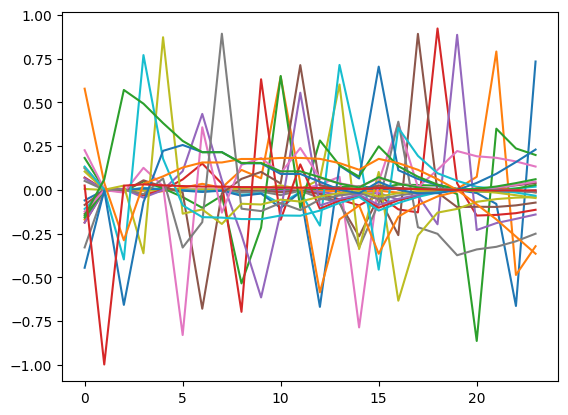

In [24]:
w, v = np.linalg.eig(h)
print(w,v)
plt.plot(v)

In [25]:
# def spectral_likelihood(i):
#     Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z = i
#     h = 1
#     G = np.diag([ a, b, c, d, e, f, g, i, h, l, m, n, o, p, q, r, s, t, u, v, w, z])
#     invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
#     A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
#     logL = 0
#     AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
#     AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
#     logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
#     #print(i,logL)
#     if logL != logL:
#         return 0.0
#     return -logL

In [26]:
# tol_ = 1e-18
# x0 =np.array([1.3, 15, -2.5, 0.5, 1.2, 0.1, 2, 0.2, 0.9, 1.1, 0.3, 0.9, 1.4, 1.2, 0.4, 0.8, 0.9, 1.2, 1.3, 0.7, 0.2, 1.9, 0.9, 1.3, 1.4]) 
# min_= minimize (spectral_likelihood,x0,method='trust-constr')
# print(min_)
# print(min_.x)


In [27]:
# g1 = np.linspace(0.5,1.5,500)
# result= []
# for i in g1:
#         result.append(spectral_likelihood(np.array([1.26466502, 17.99580668 , -2.65181336 , 1.02481412 , 1.13362434 , 1.13395641,
#   1.10611243 , 1.10360917 ,i  , 1.06613316 , 1.03197411 , 1.03194025,
#   1.00891511,  0.98736361 , 0.98027652,  1.00900499 , 0.98735861  ,0.98027463,
#   0.9850154  , 1.00000578,  1.02959818 , 1.06909778 , 1.12300709 , 1.18561135])))
# print(result)

# plt.plot(g1,result,'o')
# plt.title(r'Likelihood varying g1')
# plt.xlabel(r'slope index, g1')
# plt.ylabel('Likelihood value')

In [28]:
# Bd = np.linspace(1.4,1.6,20)
# g3 = np.linspace(0.8,1.2,20)
# result = np.zeros((20,20))
# for i,val_i in enumerate(Bd):
#     for j,val_j in enumerate(g3):
#         result[i,j] = spectral_likelihood(np.array([val_i,20,-3,1,1,val_j,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))      
   
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.contourf(Bd, g3, result.T,100)
# ax.contour(Bd, g3, result.T,levels=[ np.max(result)-2.3])

# ax.set_xlabel(r'$\beta_d$')
# ax.set_ylabel(r'g3')
# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# plt.show()

In [29]:
# T = np.linspace(15,25,20)
# g3 = np.linspace(0.5,1.5,20)
# result = np.zeros((20,20))
# for i,val_i in enumerate(T):
#     for j,val_j in enumerate(g3):
#         result[i,j] = spectral_likelihood(np.array([1.54,val_i,-3,1,1,val_j,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))      
   
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.contourf(T, g3, result.T,100)
# ax.contour(T, g3, result.T,levels=[ np.max(result)-2.3])

# ax.set_xlabel(r'T')
# ax.set_ylabel(r'g3')
# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# plt.show()

In [30]:
# Bs = np.linspace(-3.2,-2.8,20)
# g3 = np.linspace(0.8,1.2,20)
# result = np.zeros((20,20))
# for i,val_i in enumerate(Bs):
#     for j,val_j in enumerate(g3):
#         result[i,j] = spectral_likelihood(np.array([1.54,20,val_i,1,1,val_j,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))      
   
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.contourf(Bs, g3, result.T,100)
# ax.contour(Bs, g3, result.T,levels=[ np.max(result)-2.3])

# ax.set_xlabel(r'$\beta_s$')
# ax.set_ylabel(r'g3')
# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
# plt.show()

In [31]:
# Bd = np.linspace(1.539,1.541,20)
# Bs = np.linspace(-3.1,-2.9,20)
# result = np.zeros((20,20))
# for i,val_i in enumerate(Bd):
#     for j,val_j in enumerate(Bs):
#         result[i,j] = spectral_likelihood(np.array([val_i,20,val_j,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))      
   
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.contourf(Bd, Bs, result.T,100)
# ax.contour(Bd, Bs, result.T,levels=[ np.max(result)-2.3])

# ax.set_xlabel(r'$\beta_d$')
# ax.set_ylabel(r'$\beta_s$')
# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# plt.show()


In [32]:
# Bd = np.linspace(1.52,1.56,20)
# T = np.linspace(19.5,20.5,20)
# result = np.zeros((20,20))
# for i,val_i in enumerate(Bd):
#     for j,val_j in enumerate(T):
#         result[i,j] = spectral_likelihood(np.array([val_i,val_j,-3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))      
   
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.contourf(Bd, T, result.T,100)
# ax.contour(Bd, T, result.T,levels=[ np.max(result)-2.3])

# ax.set_xlabel(r'$\beta_d$')
# ax.set_ylabel(r'T')
# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# plt.show()

In [33]:
# T = np.linspace(19.9,20.1,20)
# Bs = np.linspace(-3.1,-2.9,20)
# result = np.zeros((20,20))
# for i,val_i in enumerate(T):
#     for j,val_j in enumerate(Bs):
#         result[i,j] = spectral_likelihood(np.array([1.54,val_i,val_j,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))      
   
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.contourf(T, Bs, result.T,100)
# ax.contour(T, Bs, result.T,levels=[ np.max(result)-2.3])

# ax.set_xlabel(r'T')
# ax.set_ylabel(r'Betas')
# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# plt.show()